# Imports

In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.learner import model_meta
from fastai.callbacks import SaveModelCallback
# from torchvision.models import *  # import *=all the models from torchvision  
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import shutil
import joblib
import pretrainedmodels
from sklearn.metrics import (average_precision_score, 
                             balanced_accuracy_score, 
                             classification_report, 
                             f1_score, 
                             confusion_matrix, 
                             precision_score, 
                             recall_score, 
                             roc_auc_score)


from tqdm import tqdm_notebook

loss_dict = {
        "cross_entropy": CrossEntropyFlat(),
        # "focal_loss": FocalLoss(),
        # "anchor_loss": AnchorLoss(),
        # "lovasz_softmax": lovasz_softmax_flat,
    }

%reload_ext autoreload
%autoreload 2
%matplotlib inline

ModuleNotFoundError: No module named 'custom_callbacks_samplers'

# Config

In [ ]:
CWD = Path.cwd()

root_path = CWD / 'dataset_covid'
train_path = root_path / "train"
test_path = root_path / "test"
model_save_dir = 'models'
WAND_LOGGING = False
if WAND_LOGGING:
    import wandb
    from wandb.fastai import WandbCallback

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
config = dict()

config['transforms'] = dict(do_flip=True, 
                      flip_vert=False,
                      max_rotate=10.0, 
                      max_zoom=1.1, 
                      max_lighting=0.2, 
                      max_warp=0.2, 
                      p_affine=0.75, 
                      p_lighting=0.75)
config['extra_transforms'] = [cutout(n_holes=(1,4), length=(20, 50), p=.5)]
config['loss'] = "cross_entropy"

# Setup

In [ ]:
train = pd.read_csv(root_path/"train_split.txt", sep=' ', header=None, names=['id','Image','Class']).drop('id',axis=1)
test = pd.read_csv(root_path/"test_split.txt", sep=' ', header=None, names=['id','Image','Class']).drop('id',axis=1)
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=42)
train_idx, val_idx = next(cv.split(train['Image'],train['Class']))

data = None
def get_data_bunch(n_workers=4, reload=False):
    global data
    if reload:
        data = None
    tfms_args = config['transforms']
    tfms_args['xtra_tfms'] = config['extra_transforms']
    tfms = get_transforms(**tfms_args)
    if data is None:
        data = (ImageList.from_df(train, path = train_path)
        #         .split_by_rand_pct(0.1)
                .split_by_idxs(train_idx.tolist(), val_idx.tolist())
                .label_from_df(cols=['Class'])
                .transform(tfms=tfms, size=config['image_size']) 
                # We have our custom transformations implemented in the image loader but we could apply transformations also here
                # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
        #         .normalize()
               .add_test(ImageList.from_df(test, path=test_path))
                .databunch(bs=config['batch_size'], num_workers = n_workers)
                .normalize()
               )
    return data

# "pretrained" is hardcoded to adapt to the PyTorch model function
def xception(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.xception(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))


model_meta[xception] = { 'cut': -1, 'split': lambda m: (m[0][11], m[1]) }


# def resnext101_32x4d(pretrained=False):
#     pretrained = 'imagenet' if pretrained else None
#     model = pretrainedmodels.resnext101_32x4d(pretrained=pretrained)
#     all_layers = list(model.children())
#     return nn.Sequential(*all_layers[0], *all_layers[1:])

# model_meta[resnext101_32x4d] = {'cut': -2, 'split': lambda m: (m[0][6], m[1]) }

def getLearner(saved_file, reload_data=False):
    data = get_data_bunch(reload=reload_data)
    f1_score = FBeta(beta=1, average="weighted")
    learner = cnn_learner(data, xception, 
                         pretrained=False, 
                         path='saved_models', 
                         metrics=[accuracy,f1_score], 
#                          ps=config['dropout'], 
#                          callback_fns=callback_fns,
                        loss_func = loss_dict[config['loss']])

    learner.load(saved_file)
    if reload_data:
        learner.data = data
    return learner


def get_prediction(learner, dataset_type, tta=False):
    if tta:
        pred_prob, _ = learner.TTA(ds_type=dataset_type)
    else:
        pred_prob, _ = learner.get_preds(ds_type=dataset_type)
    pred_classes = torch.argmax(pred_prob, axis=1).numpy()
    pred_classes = [learner.data.classes[i] for i in pred_classes.tolist()]
    if dataset_type == DatasetType.Test:
        df = test.copy()
    else:
        df = train.iloc[val_idx].copy()
    df['prediction'] = pred_classes
    pred_prob_cols = ["pred_prob_{}".format(cls) for cls in learner.data.classes]
    for i, col in enumerate(pred_prob_cols):
        df[col] = pred_prob[:,i]
    return df

In [6]:
from plot_utils import plot_confusion_matrix
import seaborn as sns

# Test Inference

In [7]:
config['batch_size'] = 32
config['image_size'] = 224
filepath = CWD/'saved_models'

In [8]:
def plot_save_classification_report(y_true, y_pred, model_name, save=True):
    class_report = classification_report(y_true, y_pred, output_dict=True)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_axes([0.1,0.05,.9,0.9])
    sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T*100, annot=True, fmt=".4g",ax=ax)
    ax.set_title(model_name)
#     plt.tight_layout()
    if save:
        fig.savefig('output/classification_report_{}.png'.format(model_name))
        plt.close()
    else:
        plt.show()

In [9]:
def plot_save_confusion_matrix(y_true, y_pred,labels, model_name, save=True):
    conf_matrix = confusion_matrix(y_true, y_pred, labels)
    fig = plot_confusion_matrix(conf_matrix, 
                                target_names=learner.data.classes, 
                                normalize=False,
                                title = model_name,
                                ret_fig=True)
    plt.tight_layout()
    if save:
        fig.savefig('output/confusion_matrix_{}.png'.format(model_name))
        plt.close()
    else:
        plt.show()

In [10]:
def generate_model_analysis(pred_df, model_name):
    plot_save_classification_report(y_true = test.Class, y_pred=pred_df.prediction, model_name = model_name, save=False)
    plot_save_confusion_matrix(y_true = test.Class,
                            y_pred = pred_df.prediction,
                            labels=learner.data.classes,
                               model_name = model_name, save=False)

In [11]:
best_single_model = 'xception_cross_entropy_fastai_mixup_ft_stage_1'

In [12]:
filename = CWD/'saved_models'/best_single_model
learner = getLearner(reload_data=True, saved_file=filename)

In [13]:
%%time
test_pred_df = get_prediction(learner, DatasetType.Test)

Wall time: 28.8 s


In [14]:
28.2/len(learner.data.label_list.lists[2])

0.044131455399061034

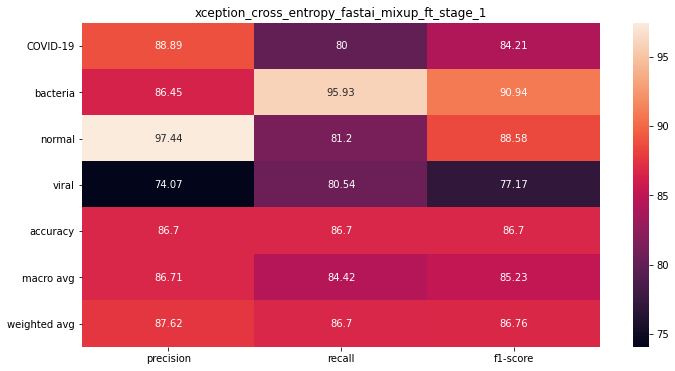

In [44]:
generate_model_analysis(test_pred_df, best_single_model)

In [14]:
test_pred_df.to_csv(CWD/"output"/(best_single_model+".csv"))

### Grad CAM

In [13]:
val_df = train.iloc[val_idx].reset_index()
interp = ClassificationInterpretation.from_learner(learner, DatasetType.Valid)
interp.pred_class = [learner.data.classes[cl] for cl in interp.pred_class]
def plot_gradcam(idx):
    im,cl = learner.data.dl(DatasetType.Valid).dataset[idx]
    cl = int(cl)
    xb,_ = learner.data.one_item(im, detach=False, denorm=False) #put into a minibatch of batch size = 1
    mult = interp.GradCAM(idx, DatasetType.Valid, image=False)
    xb_im = Image(xb[0])
    fig = plt.figure(figsize=(7,7))
    ax = fig.subplots()
    sz = list(xb_im.shape[-2:])
    xb_im.show(ax,title=f"pred. class: {interp.pred_class[idx]}, actual class: {learner.data.classes[cl]}")
    ax.imshow(mult, alpha=0.7, extent=(0,*sz[::-1],0),
      interpolation='bilinear', cmap='magma')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


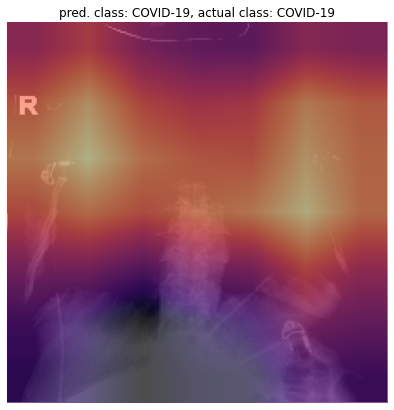

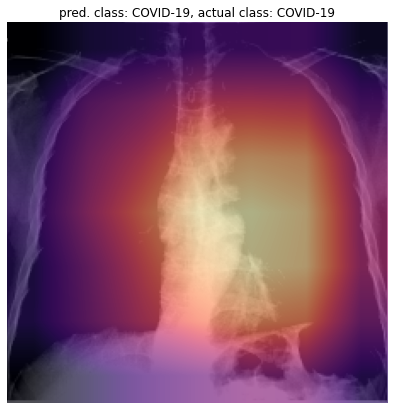

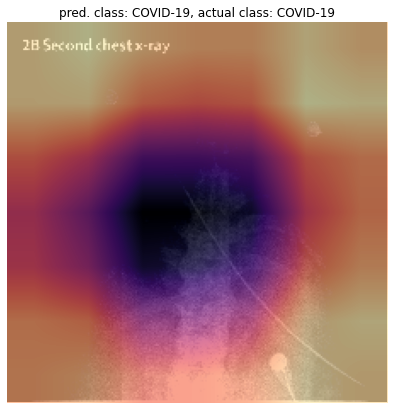

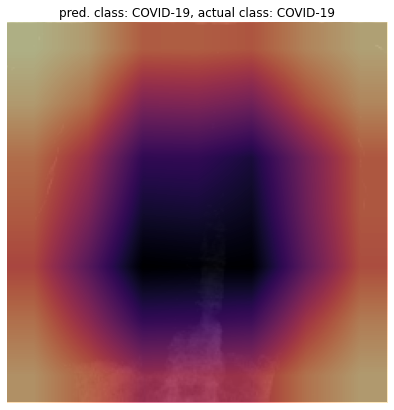

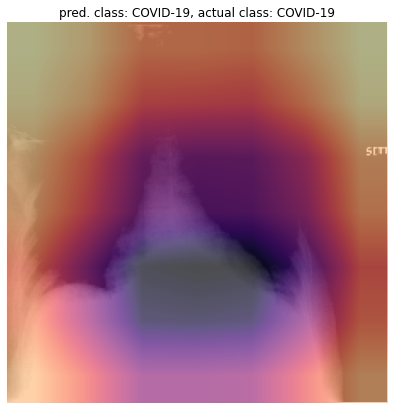

In [14]:
for idx in val_df[val_df['Class']=='COVID-19'].index:
    plot_gradcam(idx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

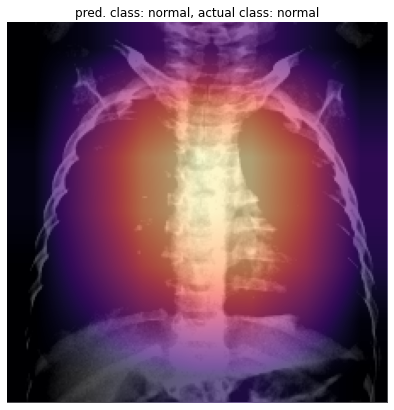

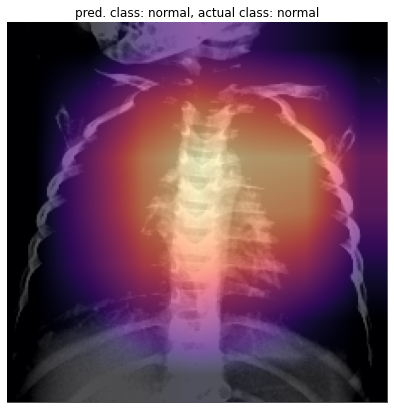

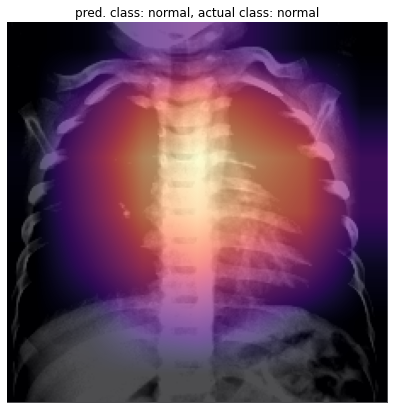

In [18]:
for idx in val_df[val_df['Class']=='normal'].sample(10,random_state=123).index:
    plot_gradcam(idx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

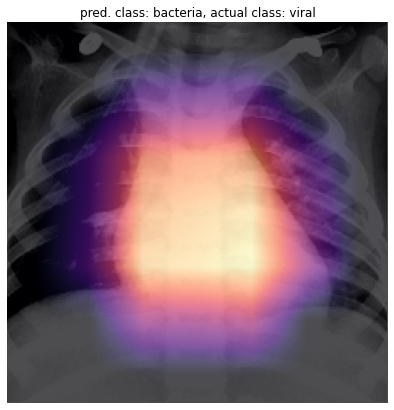

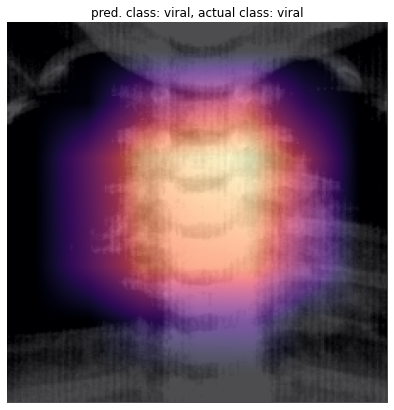

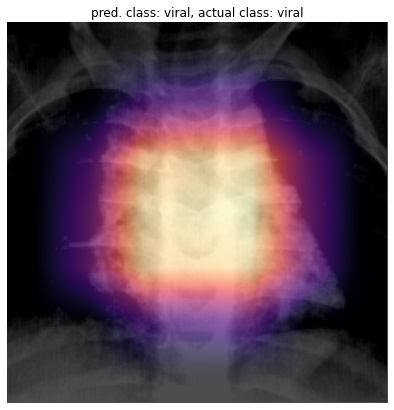

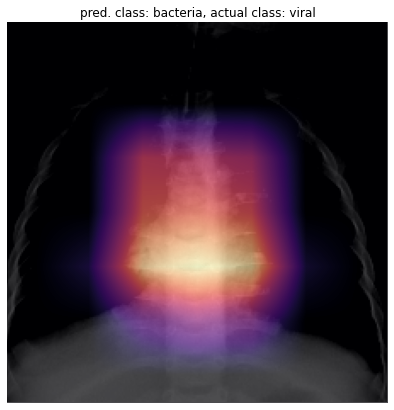

In [19]:
for idx in val_df[val_df['Class']=='viral'].sample(10,random_state=123).index:
    plot_gradcam(idx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

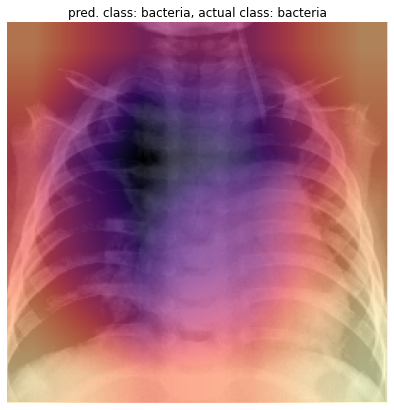

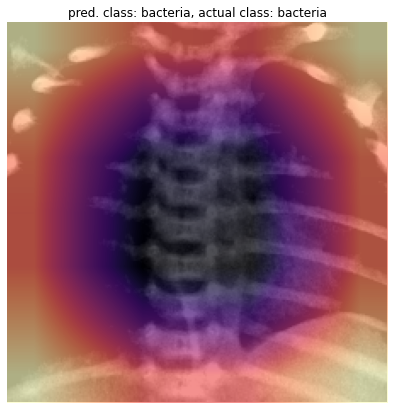

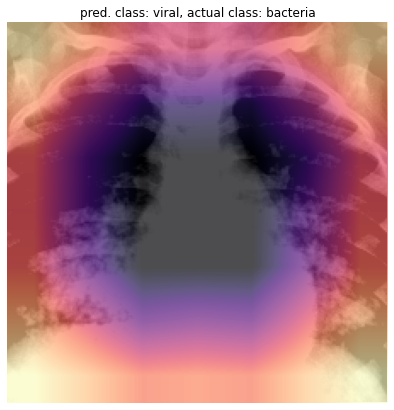

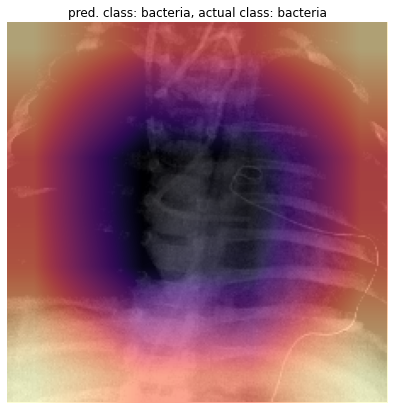

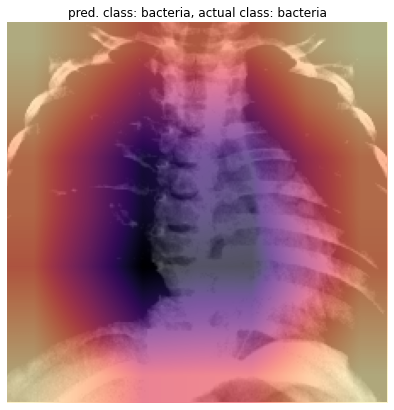

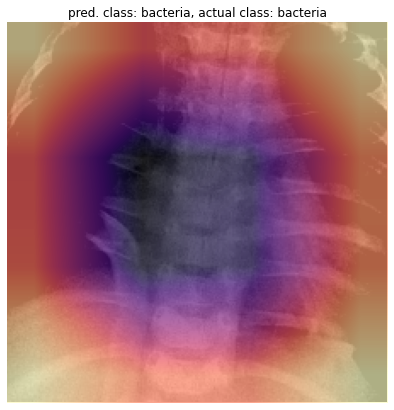

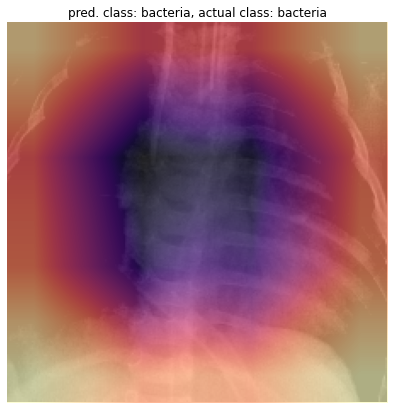

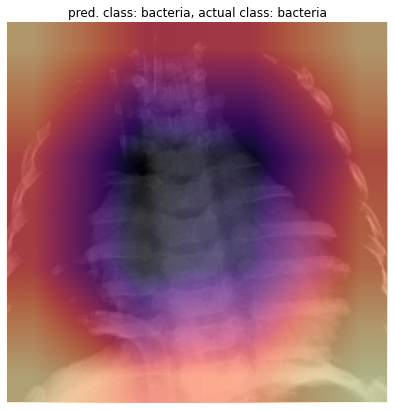

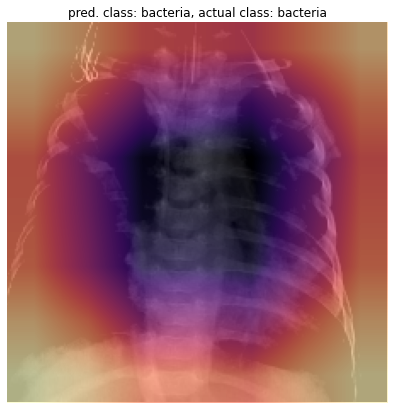

In [20]:
for idx in val_df[val_df['Class']=='bacteria'].sample(10,random_state=123).index:
    plot_gradcam(idx)